# Advent of Code - D03: Gear Ratios

@author: Camillo Moschner

# Import Staments

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
from skimage.measure import label
from skimage.morphology import binary_dilation
from tqdm.notebook import tqdm

# Solve Part 1

## Load Data

In [2]:
test_data ="""467..114..
...*......
..35..633.
......#...
617*......
.....+.58.
..592.....
......755.
...$.*....
.664.598..
"""

In [3]:
with open('D03ab_input.txt', 'r') as file:
    puzzle_input_BOTH = file.read()

In [4]:
def convert_to_int(line_list: list) -> list:
    """ Change dtype of all elements of the list to int if they are integers
    """
    str_to_no_dict = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9} 
    return [str_to_no_dict.get(x, -5) for x in line_list]

In [5]:
convert_to_int(['6', '1', '7', '*', '.', '.', '.', '.', '.', '.'])

[6, 1, 7, -5, -5, -5, -5, -5, -5, -5]

In [6]:
def identify_special_characters(line_list: list) -> list:
    return [all([not x.isalnum(), x!='.']) for x in line_list]

In [7]:
identify_special_characters(['6', '1', '7', '*', '.', '.', '.', '.', '.', '.'])

[False, False, False, True, False, False, False, False, False, False]

In [8]:
# def contains_negative_3x3_with_padding(input_array: np.array) -> np.array: SUPERSEEDED BY BINARY_DILATION EPIPHANY
#     # Pad the array with zeros on all sides
#     padded_array = np.pad(input_array, pad_width=1, mode='constant', constant_values=0)
#     rows, cols = padded_array.shape
#     result = np.zeros((rows-2, cols-2), dtype=bool)
#     for i in range(rows - 2):
#         for j in range(cols - 2):
#             block = padded_array[i:i+3, j:j+3]
#             result[i, j] = np.any(block < -5)
#     return result

def horizontal_label(array: np.array) -> np.array:
    """ scikit-image's label() function cannot by itsel label only in the horizontal dimension.
        -> This function therefore labels row by row instead to generate this functionality.
    """
    labeled_rows = []
    max_label = 0  # Keep track of the maximum label used so far
    for row in array:
        # Apply label() to each row
        labeled_row = label(row > 0, connectivity=1)
        # Adjust labels to ensure uniqueness across rows
        labeled_row[labeled_row > 0] += max_label
        if labeled_row.max() != 0:
            max_label = labeled_row.max()
        # Append the labeled row to the list
        labeled_rows.append(labeled_row)
    # Combine labeled rows into a single array
    labeled_array = np.vstack(labeled_rows)
    return labeled_array

## Compressing approach into easy-to-use function

In [9]:
def find_part_numbers(text_input: str, visualise: bool = False) -> int:
    """
    """
    engine_number_arr = np.array( [convert_to_int(list(line)) for line in text_input.splitlines()] )
    engine_special_char_arr = np.array( [identify_special_characters(list(line)) for line in text_input.splitlines()] )
    # Combine information into processed input data
    processed_engine_schematic_arr = engine_number_arr-engine_special_char_arr
    # Identify all positions that are neighbours to a special character
    identified_neighbours_arr = binary_dilation(engine_special_char_arr, footprint=np.ones((3,3))) #contains_negative_3x3_with_padding(processed_engine_schematic_arr)
    # Overlap numbers and neighbours position, highlighting which number has a sub-component that is also a neighbour
    number_plus_neighbour_arr = (processed_engine_schematic_arr>-5).astype(int) + identified_neighbours_arr.astype(int)
    # Label number positions to rejoin digits into complete numbers
    labelled_engine_schematic_arr = horizontal_label(processed_engine_schematic_arr>-5)
    if visualise == True:
        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 6))
        ax1.imshow(engine_number_arr), ax1.set_title('Find all\nnumbers')
        ax2.imshow(engine_special_char_arr), ax2.set_title('Find all\nspecial charcters')
        ax3.imshow(processed_engine_schematic_arr), ax3.set_title('Combine\ninformation')
        ax4.imshow(identified_neighbours_arr), ax4.set_title('Positions with\nspecial neighbour')
        ax5.imshow(number_plus_neighbour_arr), ax5.set_title('Number parts next\n to special character')
        ax6.imshow(labelled_engine_schematic_arr), ax6.set_title('Labelled numbers')
        plt.tight_layout()
        plt.show()
    # Select for numbers in which at least one digit is a neighbour to a special character
    identified_part_numbers_list = [
        int(''.join([str(x) for x in processed_engine_schematic_arr[labelled_engine_schematic_arr==idx]])) for idx in range(1,labelled_engine_schematic_arr.max()+1) 
        if 2 in number_plus_neighbour_arr[labelled_engine_schematic_arr==idx]
    ]
    # print([number_plus_neighbour_arr[labelled_engine_schematic_arr==idx] for idx in range(1,labelled_engine_schematic_arr.max()+1)])
    # print(identified_part_numbers_list)
    return sum(identified_part_numbers_list)

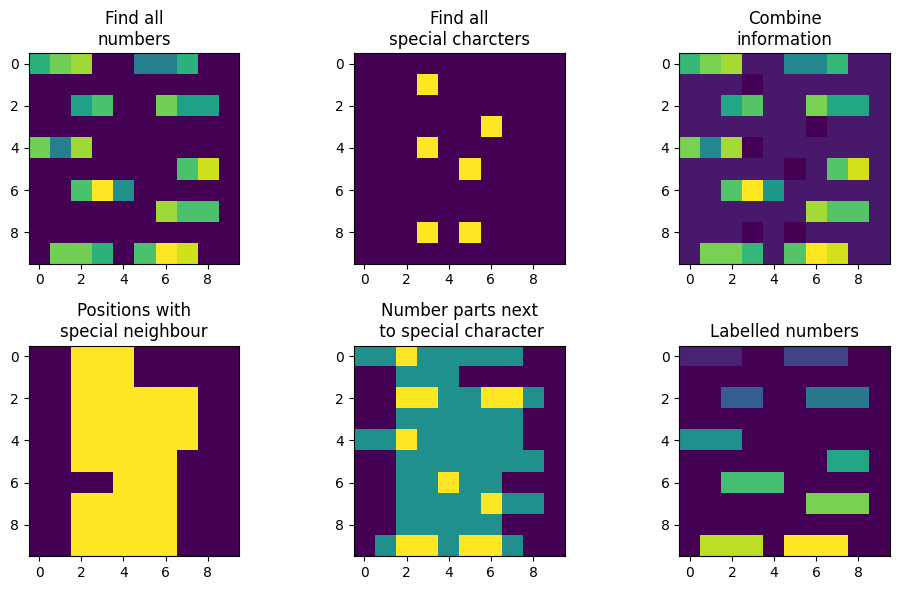

4361

In [10]:
find_part_numbers(test_data, visualise=True)

In [11]:
further_testing = """12.......*..
+.........34
.......-12..
..78........
..*....60...
78..........
.......23...
....90*12...
............
2.2......12.
.*.........*
1.1.......56
"""

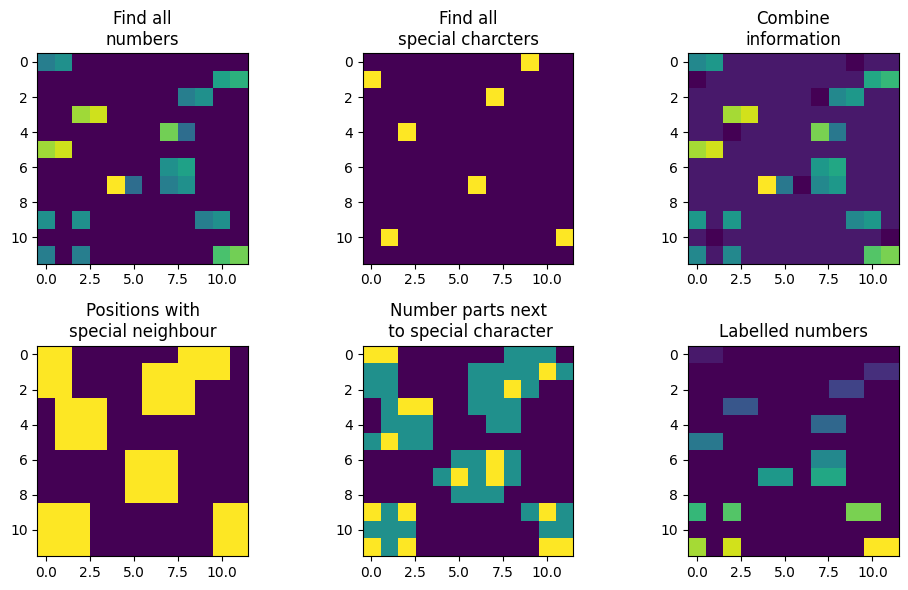

CPU times: user 376 ms, sys: 821 Âµs, total: 377 ms
Wall time: 408 ms


413

In [12]:
%%time
find_part_numbers(further_testing, visualise=True)

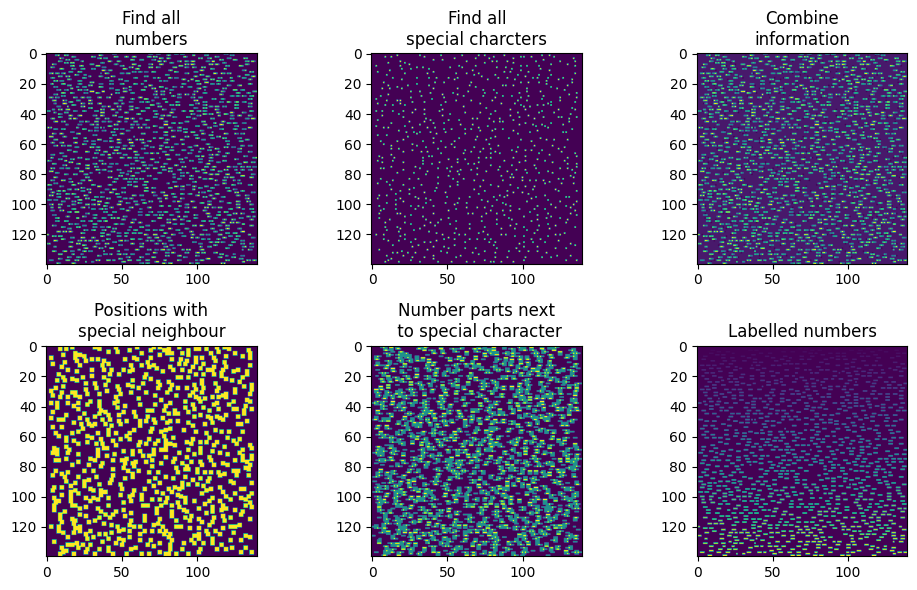

CPU times: user 391 ms, sys: 18.7 ms, total: 410 ms
Wall time: 442 ms


536202

In [13]:
%%time
find_part_numbers(puzzle_input_BOTH, visualise=True)

# Solve Part 2

## Load Data

In [14]:
def identify_number(line_list: list) -> list:
    return [x.isalnum() for x in line_list]

def identify_gears(line_list: list) -> list:
    return [x=='*' for x in line_list]

In [15]:
def find_gear_ratios(text_input: str, visualise: bool = False) -> int:
    pure_no_mask_arr = horizontal_label(np.array( [identify_number(list(line)) for line in text_input.splitlines()] ))
    engine_gears_arr = np.array( [identify_gears(list(line)) for line in text_input.splitlines()] )
    engine_number_arr = np.array( [convert_to_int(list(line)) for line in text_input.splitlines()] )
    # Find gear adjacent to exactly two part numbers
    identified_gear_pos_list = []
    for gear_pos in tqdm(list(zip(*np.where(engine_gears_arr)))):
        # Investigate each gears neighbourhood
        new_arr = np.zeros(engine_gears_arr.shape)
        new_arr[gear_pos] = 1
        current_engine_neibours = binary_dilation(new_arr, footprint=np.ones((3,3)))
        adjacent_number_labels = np.unique(pure_no_mask_arr[current_engine_neibours])
        # Save gear position and number labels found in that neighbourhood if there are exactly TWO numbers in that neighbourhood
        if len(adjacent_number_labels) == 3:
            identified_gear_pos_list.append(adjacent_number_labels[adjacent_number_labels>0])
    # Go through gear 'hits', identify adjacent numbers, and calculate their product
    gear_ratios = []
    for label_duo in identified_gear_pos_list:
        no_one = int(''.join([str(digit) for digit in engine_number_arr[pure_no_mask_arr==label_duo[0]]]))
        no_two = int(''.join([str(digit) for digit in engine_number_arr[pure_no_mask_arr==label_duo[1]]]))
        gear_ratios.append(no_one*no_two)
    if visualise == True:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 6))
        ax1.imshow(pure_no_mask_arr), ax1.set_title('Label all\nnumbers') 
        ax2.imshow(engine_gears_arr), ax2.set_title('Find all\ngears')
        ax4.imshow(binary_dilation(engine_gears_arr.astype(int), footprint=np.ones((3,3))) ), ax4.set_title('All gear\nneighbourhoods')
        ax3.imshow(engine_number_arr), ax3.set_title('Find all\nnumbers')
        plt.tight_layout()
        plt.show()
    return sum(gear_ratios)

  0%|          | 0/3 [00:00<?, ?it/s]

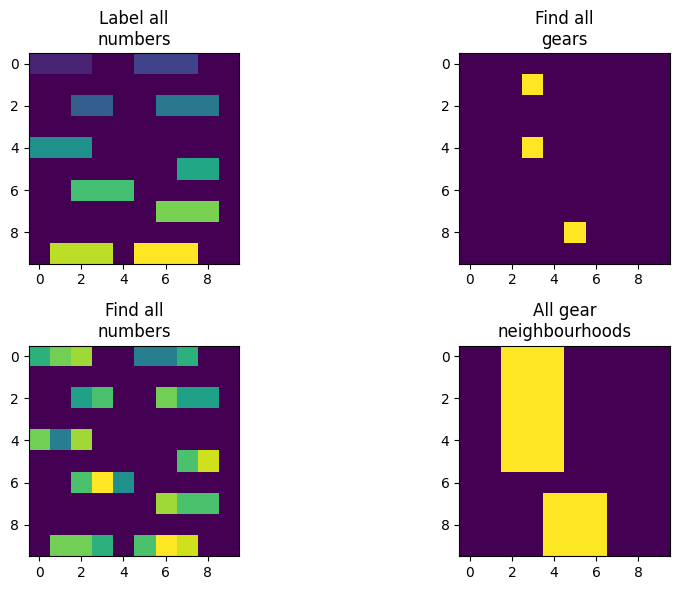

467835

In [16]:
find_gear_ratios(test_data, visualise=True)

  0%|          | 0/364 [00:00<?, ?it/s]

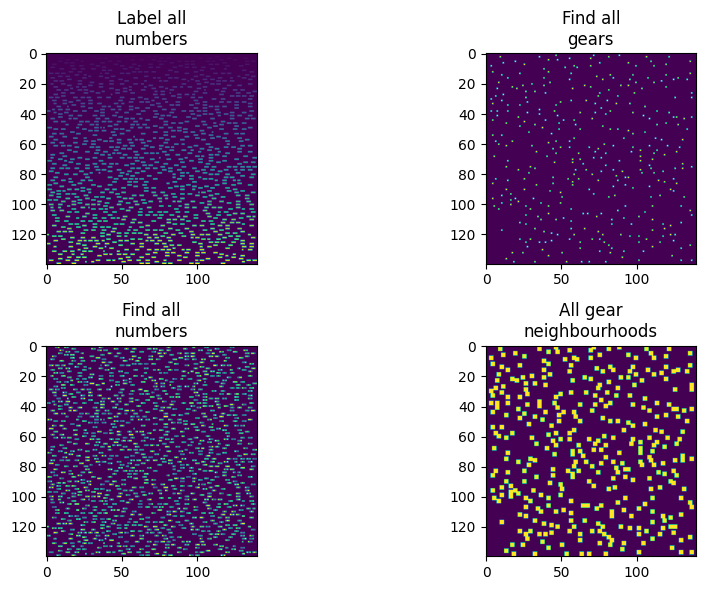

78272573

In [17]:
find_gear_ratios(puzzle_input_BOTH, visualise=True)